In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('/content/ALL_FAIL_LOG_GPS_0_Add_Num_Random.csv')

In [ ]:
print("Dataset Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nSample Data:\n", data.head())
print("\nMissing Values:\n", data.isnull().sum())

Dataset Shape: (4319, 17)

Columns:
 Index(['LineNo', 'TimeUS', 'I', 'Status', 'GMS', 'GWk', 'NSats', 'HDop', 'Lat',
       'Lng', 'Alt', 'Spd', 'GCrs', 'VZ', 'Yaw', 'U', 'labels'],
      dtype='object')

Sample Data:
    LineNo     TimeUS  I  Status        GMS   GWk  NSats  HDop        Lat  \
0  186120  238603687  0       6  547888600  2232     10  1.21 -35.360988   
1   70202  109203801  0       1  547759200  2232      3  1.21 -35.362661   
2   37211   72603447  0       6  547722600  2232     10  1.21 -35.363286   
3  426537  505803431  0       6  548155800  2232     10  1.21 -35.363284   
4  319397  386803550  0       6  548036800  2232     10  1.21 -35.361890   

          Lng    Alt    Spd       GCrs     VZ  Yaw  U  labels  
0  149.163326  48.64  1.700   29.63562 -1.197    0  1       0  
1  149.162593  39.94  3.885  327.20960  0.031    0  1       1  
2  149.163059  39.94  0.025  303.80130 -0.009    0  1       0  
3  149.163061  20.39  0.000  258.62220  0.000    0  1       4  
4  1

In [ ]:
print("\nData Types:\n", data.dtypes)


Data Types:
 LineNo      int64
TimeUS      int64
I           int64
Status      int64
GMS         int64
GWk         int64
NSats       int64
HDop      float64
Lat       float64
Lng       float64
Alt       float64
Spd       float64
GCrs      float64
VZ        float64
Yaw         int64
U           int64
labels      int64
dtype: object


labels
0    2031
4     687
2     618
1     569
3     414
Name: count, dtype: int64


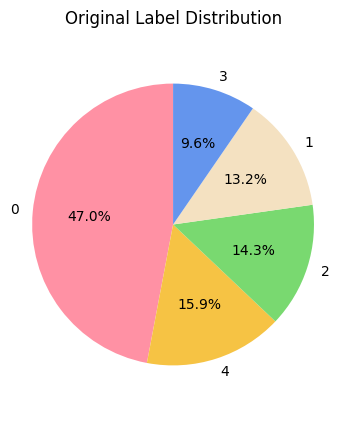

In [ ]:
if 'labels' in data.columns:
    label_counts = data['labels'].value_counts()
    print(label_counts)
    # Define specific colors for 5 labels
    colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]
    # Plot the pie chart
    plt.figure(figsize=(4, 5))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.axis('equal')
    plt.title('Original Label Distribution')
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Encoding Categorical Data
if 'labels' in data.columns:
    label_encoder = LabelEncoder()
    data['labels'] = label_encoder.fit_transform(data['labels'])
    print("\nLabel Encoding Complete. Classes:", label_encoder.classes_)


Label Encoding Complete. Classes: [0 1 2 3 4]


In [ ]:
# Feature Selection
X = data.drop(columns=['labels']).values  # Features
y = data['labels'].values  # Target

In [ ]:
# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(np.unique(y)))

In [ ]:
# Reshaping for TCN (samples, time_steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [ ]:
X_reshaped.shape

(4319, 1, 16)

In [ ]:
# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

In [ ]:
# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

In [ ]:
# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model

In [ ]:
# Input shape for TCN
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
num_classes = y_encoded.shape[1]

In [ ]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
label_accuracies = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_fold, X_val_fold = X_reshaped[train_index], X_reshaped[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    model = build_tcn_attention_model(input_shape, num_classes)
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracy:.4f}")
    accuracies.append(accuracy)

    # Predictions
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Accuracy per label
    label_acc = []
    for label in range(num_classes):
        label_indices = (y_true_classes == label)
        label_acc.append(accuracy_score(y_true_classes[label_indices], y_pred_classes[label_indices]))
    label_accuracies.append(label_acc)

    fold_no += 1

# model.summary()


Training fold 1...
Validation Accuracy for fold 1: 0.9931
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Training fold 2...
Validation Accuracy for fold 2: 0.9838
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Training fold 3...
Validation Accuracy for fold 3: 0.9815
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

Training fold 4...
Validation Accuracy for fold 4: 0.9826
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

Training fold 5...
Validation Accuracy for fold 5: 0.9803
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [ ]:
# Calculate average accuracy
average_accuracy = np.mean(accuracies)
print(f"\nAverage Accuracy across all folds: {average_accuracy:.4f}")


Average Accuracy across all folds: 0.9843


In [ ]:
# Average accuracy per label
label_accuracies = np.mean(label_accuracies, axis=0)
for idx, acc in enumerate(label_accuracies):
    print(f"Label {idx} Accuracy: {acc:.4f}")

Label 0 Accuracy: 0.9823
Label 1 Accuracy: 0.9877
Label 2 Accuracy: 0.9878
Label 3 Accuracy: 0.9786
Label 4 Accuracy: 0.9871


In [ ]:
# Evaluate the last fold predictions
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_fold, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes,digits = 4))


Classification Report:

              precision    recall  f1-score   support

           0     0.9899    0.9680    0.9788       406
           1     0.9821    0.9821    0.9821       112
           2     0.9861    1.0000    0.9930       142
           3     0.8889    1.0000    0.9412        72
           4     1.0000    0.9847    0.9923       131

    accuracy                         0.9803       863
   macro avg     0.9694    0.9870    0.9775       863
weighted avg     0.9814    0.9803    0.9805       863



27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
0    397
2    144
4    129
1    112
3     81
Name: count, dtype: int64


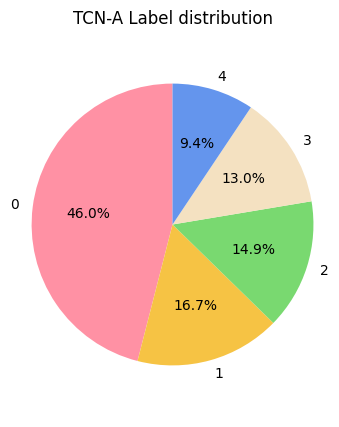

In [ ]:
# Get the label distribution after training
# Get the predicted labels after training (from the last fold or the final model)
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
class_counts = pd.Series(y_pred_classes).value_counts()
print(class_counts)
colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]

# Plot pie chart of predicted labels
plt.figure(figsize=(4, 5))
plt.pie(pd.Series(y_pred_classes).value_counts(), labels=label_encoder.classes_, autopct='%1.1f%%', startangle=90,colors=colors)
plt.axis('equal')
plt.title('TCN-A Label distribution')
plt.show()

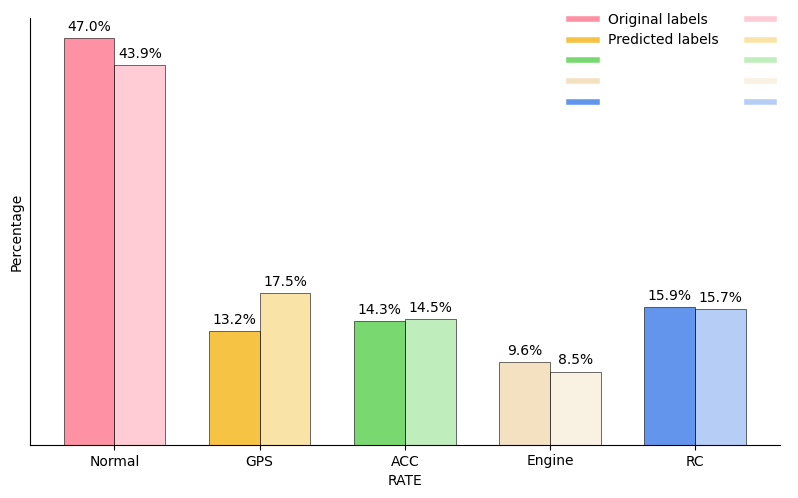

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Sample values for original and predicted counts
original_counts = np.array([4058,1138,1236,829,1377])  # Replace with your values
predicted_counts = np.array([758,302,250,146,271])  # Replace with your values

# Labels for the categories
labels = ["Normal", "GPS", "ACC", "Engine", "RC"]

# Normalize counts to percentages
original_percent = original_counts / original_counts.sum() * 100
predicted_percent = predicted_counts / predicted_counts.sum() * 100

# Define label positions
x = np.arange(len(labels))  # The label locations
width = 0.35  # Bar width

# Base colors for bars
base_colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]

# Assign colors dynamically
original_bar_colors = [base_colors[i] for i in range(len(labels))]
predicted_bar_colors = [f"{base_colors[i]}77" for i in range(len(labels))]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

bars1 = ax.bar(
    x - width / 2, original_percent, width,
    color=original_bar_colors, edgecolor="black", linewidth=0.4
)
bars2 = ax.bar(
    x + width / 2, predicted_percent, width,
    color=predicted_bar_colors, edgecolor="black", linewidth=0.4
)

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Style the X and Y axes
ax.spines["left"].set_linewidth(0.8)
ax.spines["bottom"].set_linewidth(0.8)

# Remove Y-axis values
ax.set_yticks([])

# Add labels, title, and custom ticks
ax.set_xlabel('RATE')
ax.set_ylabel('Percentage')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Annotate bar heights
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

legend_elements = [
    plt.Line2D([0], [0], color=base_colors[0], lw=4, label="Original labels"),
    plt.Line2D([0], [0], color=base_colors[1],lw=4, label="Predicted labels"),
    plt.Line2D([0], [0], color=base_colors[2], lw=4),
    plt.Line2D([0], [0], color=base_colors[3], lw=4),
    plt.Line2D([0], [0], color=base_colors[4], lw=4),
    plt.Line2D([0], [0], color=f"{base_colors[0]}77", lw=4),
    plt.Line2D([0], [0], color=f"{base_colors[1]}77", lw=4),
    plt.Line2D([0], [0], color=f"{base_colors[2]}77",lw=4),
    plt.Line2D([0], [0], color=f"{base_colors[3]}77",lw=4),
    plt.Line2D([0], [0], color=f"{base_colors[4]}77",lw=4),
]
fig.legend(handles=legend_elements, loc="upper right", ncol=2, fontsize=10, frameon=False)

plt.tight_layout()
plt.show()


In [ ]:
# Create the 15 charts grid layout (5 rows x 3 columns)
fig, axes = plt.subplots(5, 3, figsize=(18, 20), subplot_kw={"polar": True})

# Angles for polar plots (4 datasets + loop closure)
angles = np.linspace(0, 2 * np.pi, 4, endpoint=False).tolist()
angles += angles[:1]

# Titles for metrics
metric_titles = ["F1 Score", "Accuracy", "Recall"]

# Plot for each label and metric
for row_idx, label in enumerate(labels):  # Loop over labels
    for col_idx, metric in enumerate(metrics):  # Loop over metrics
        ax = axes[row_idx, col_idx]
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)

        # Dataset labels on plot
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(datasets)

        # Plot data for both models (stacked rings)
        for model_idx, model in enumerate(models):
            values = data[metric][model][row_idx]  # Data for the current label and metric
            values += values[:1]  # Close the loop

            # Plotting the rings (offset for stacking)
            ax.plot(angles, np.array(values) + model_idx * 0.1, label=f"{model}", alpha=0.7)
            ax.fill(angles, np.array(values) + model_idx * 0.1, alpha=0.1)

        # Set title for columns (metrics)
        if row_idx == 0:
            ax.set_title(metric_titles[col_idx], fontsize=14, fontweight="bold")

        # Set y-label for rows (labels)
        if col_idx == 0:
            ax.set_ylabel(label, labelpad=20, fontsize=12, fontweight="bold", rotation=0)

# Adjust layout and add a legend
fig.legend(models, loc="lower center", ncol=2, fontsize=12, frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust space for legend
plt.show()


NameError: name 'plt' is not defined

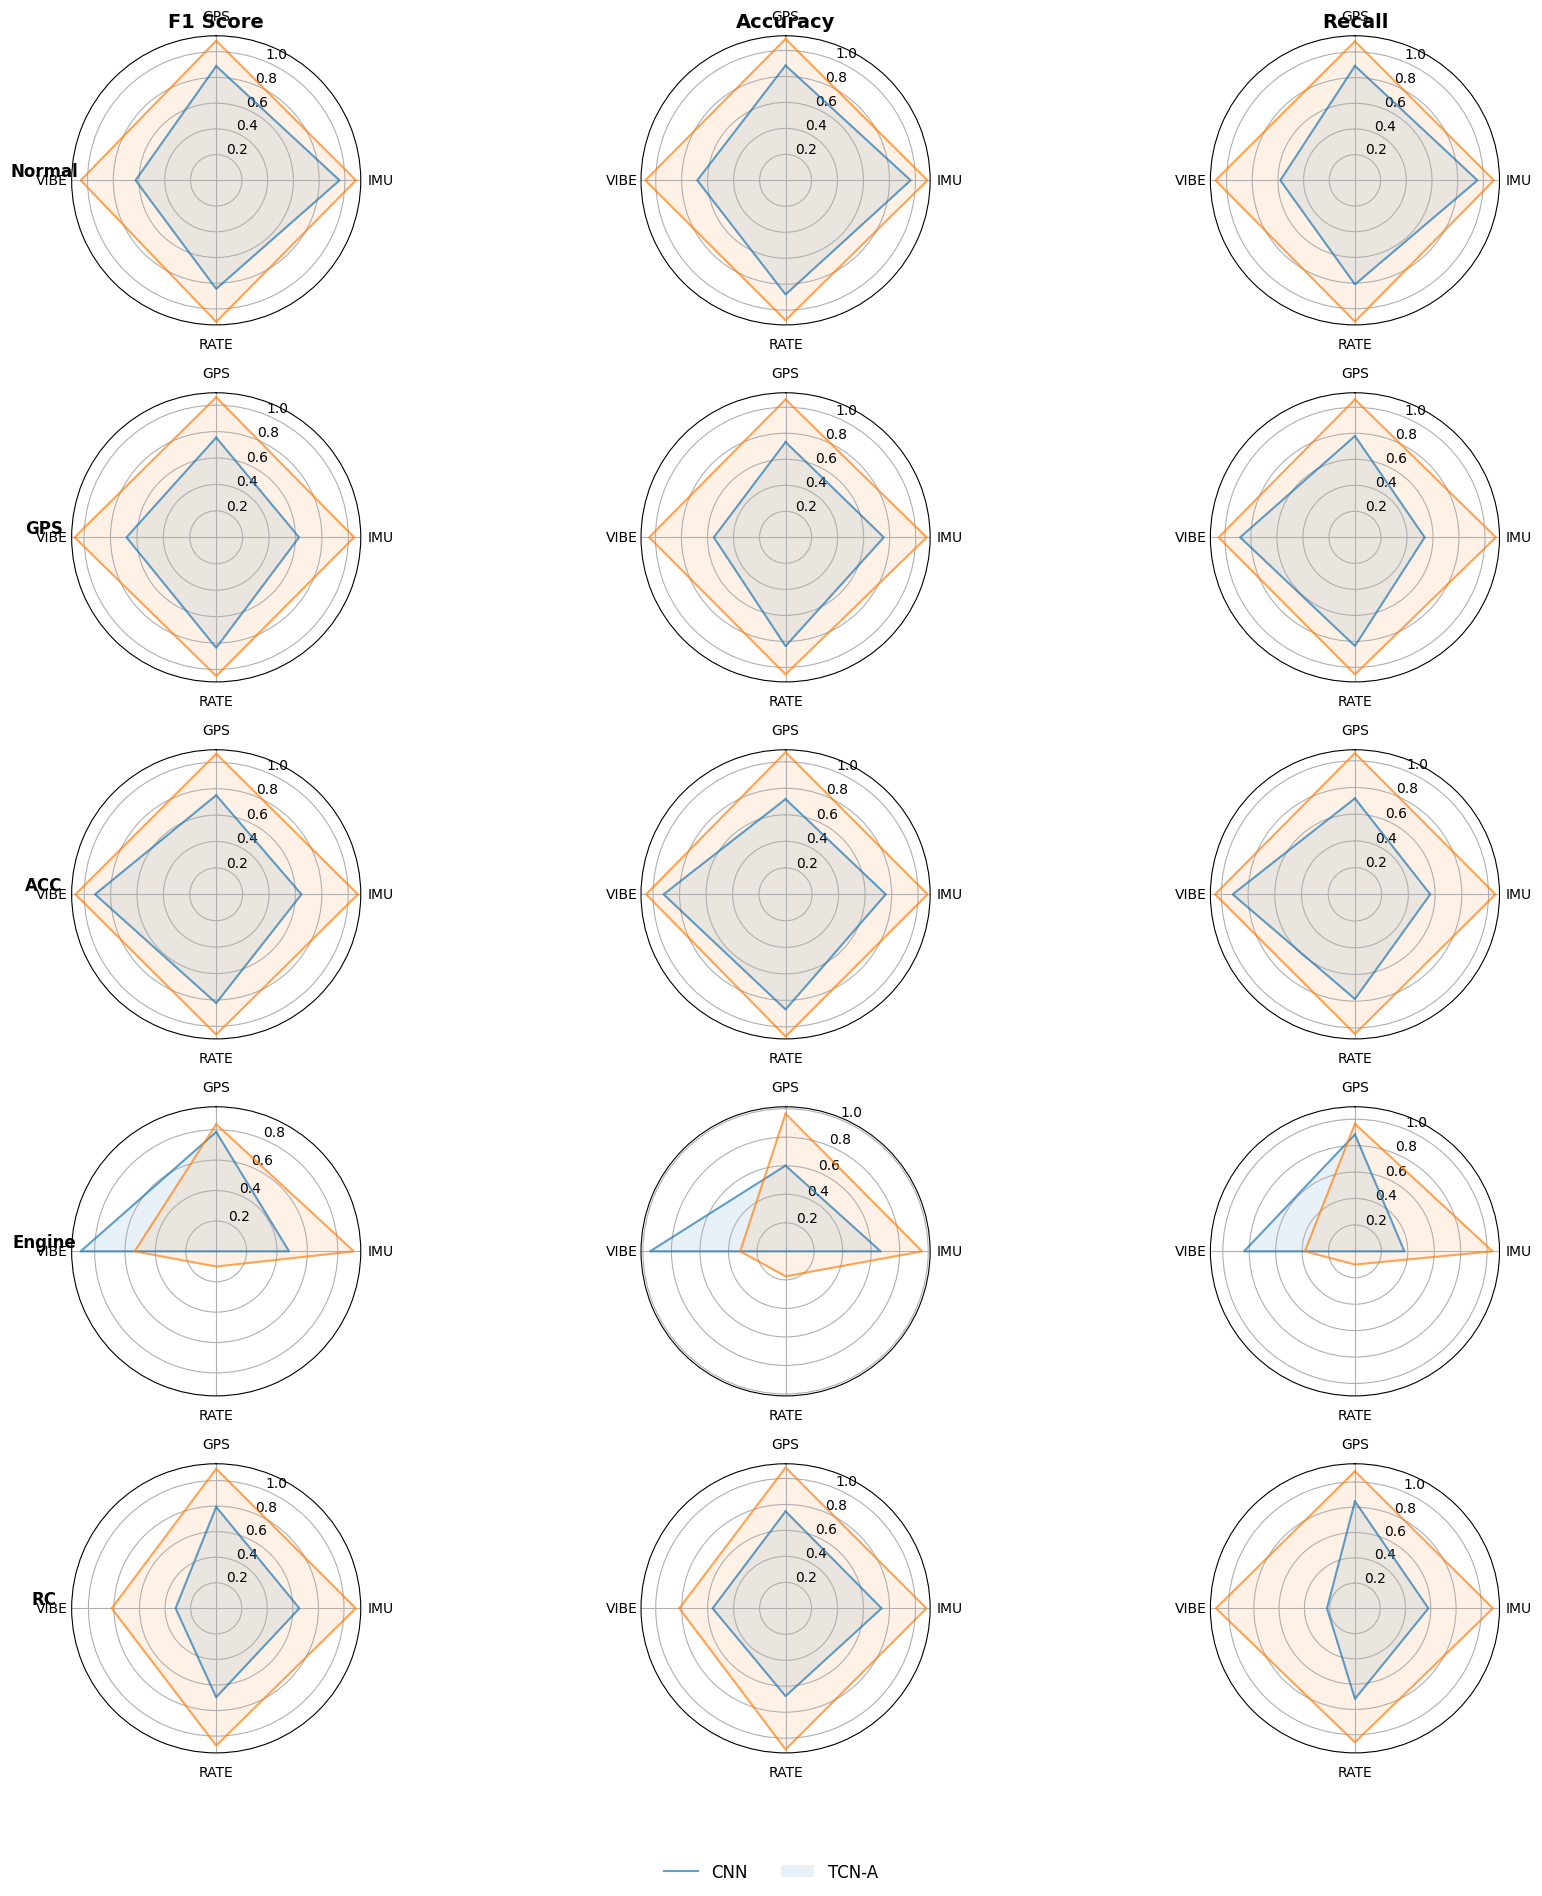

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data reference from the image (replace dummy data with real values as needed)
data = {
    "Accuracy": {
        "CNN": [[0.8846, 0.9632, 0.8792, 0.6802],
                [0.7325, 0.7551, 0.8364, 0.5516],
                [0.7186, 0.7560, 0.8687, 0.9207],
                [0.6010, 0.6666, 0.0000, 0.9512],
                [0.7470, 0.7395, 0.6761, 0.5622]],
        "TCN-A": [[0.9892, 0.9927, 0.9778, 0.9802],
                  [0.9600, 0.9844, 0.9533, 0.9487],
                  [0.9730, 0.9720, 0.9727, 0.9520],
                  [0.8653, 0.8573, 0.0753, 0.2186],
                  [0.9842, 0.9847, 0.9869, 0.7184]]
    },
    "F1 Score": {
        "CNN": [[0.8881, 0.9587, 0.8436, 0.6269],
                [0.7552, 0.6271, 0.8360, 0.6790],
                [0.7506, 0.6459, 0.8240, 0.9182],
                [0.7854, 0.4796, 0.0000, 0.8919],
                [0.7939, 0.6510, 0.6959, 0.3177]],
        "TCN-A": [[0.9852, 0.9865, 1.0000, 0.9530],
                  [0.9600, 0.9434, 0.9493, 0.9717],
                  [0.9653, 0.9737, 0.9624, 0.9664],
                  [0.7363, 0.8058, 0.0000, 0.4367],
                  [0.9923, 0.9926, 0.9743, 0.7184]]
    },
    "Recall": {
        "CNN": [[0.8916, 0.9544, 0.8108, 0.5813],
                [0.7793, 0.5363, 0.8355, 0.8829],
                [0.7186, 0.5639, 0.7837, 0.9157],
                [0.8849, 0.3746, 0.0000, 0.8395],
                [0.8471, 0.5814, 0.7169, 0.2214]],
        "TCN-A": [[0.9828, 0.9821, 1.0000, 0.9861],
                  [0.9608, 0.9844, 0.9538, 0.9487],
                  [0.9576, 0.9526, 0.9455, 0.9474],
                  [0.8654, 0.9420, 0.0000, 0.2793],
                  [0.9847, 0.9917, 0.9601, 1.0000]]
    }
}

# Metadata
labels = ["Normal", "GPS", "ACC", "Engine", "RC"]
metrics = ["F1 Score", "Accuracy", "Recall"]
datasets = ["GPS", "IMU", "RATE", "VIBE"]
models = ["CNN", "TCN-A"]

# Create the 5x3 grid layout for polar charts
fig, axes = plt.subplots(5, 3, figsize=(18, 20), subplot_kw={"polar": True})

# Angles for polar plots (4 datasets + closing loop)
angles = np.linspace(0, 2 * np.pi, len(datasets), endpoint=False).tolist()
angles += angles[:1]

# Plot for each label and metric
for row_idx, label in enumerate(labels):  # Loop over labels
    for col_idx, metric in enumerate(metrics):  # Loop over metrics
        ax = axes[row_idx, col_idx]
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)

        # Dataset labels on plot
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(datasets, fontsize=10)

        # Plot data for both models (stacked rings)
        for model_idx, model in enumerate(models):
            values = data[metric][model][row_idx]  # Data for the current label and metric
            values += [values[0]]  # Close the loop (duplicate the first value)

            # Plotting the rings (offset for stacking)
            ax.plot(angles, np.array(values) + model_idx * 0.1, label=f"{model}", alpha=0.7)
            ax.fill(angles, np.array(values) + model_idx * 0.1, alpha=0.1)

        # Set title for columns (metrics)
        if row_idx == 0:
            ax.set_title(metric, fontsize=14, fontweight="bold")

        # Set y-label for rows (labels)
        if col_idx == 0:
            ax.set_ylabel(label, labelpad=20, fontsize=12, fontweight="bold", rotation=0)

# Adjust layout and add a legend
fig.legend(models, loc="lower center", ncol=2, fontsize=12, frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust space for legend
plt.show()


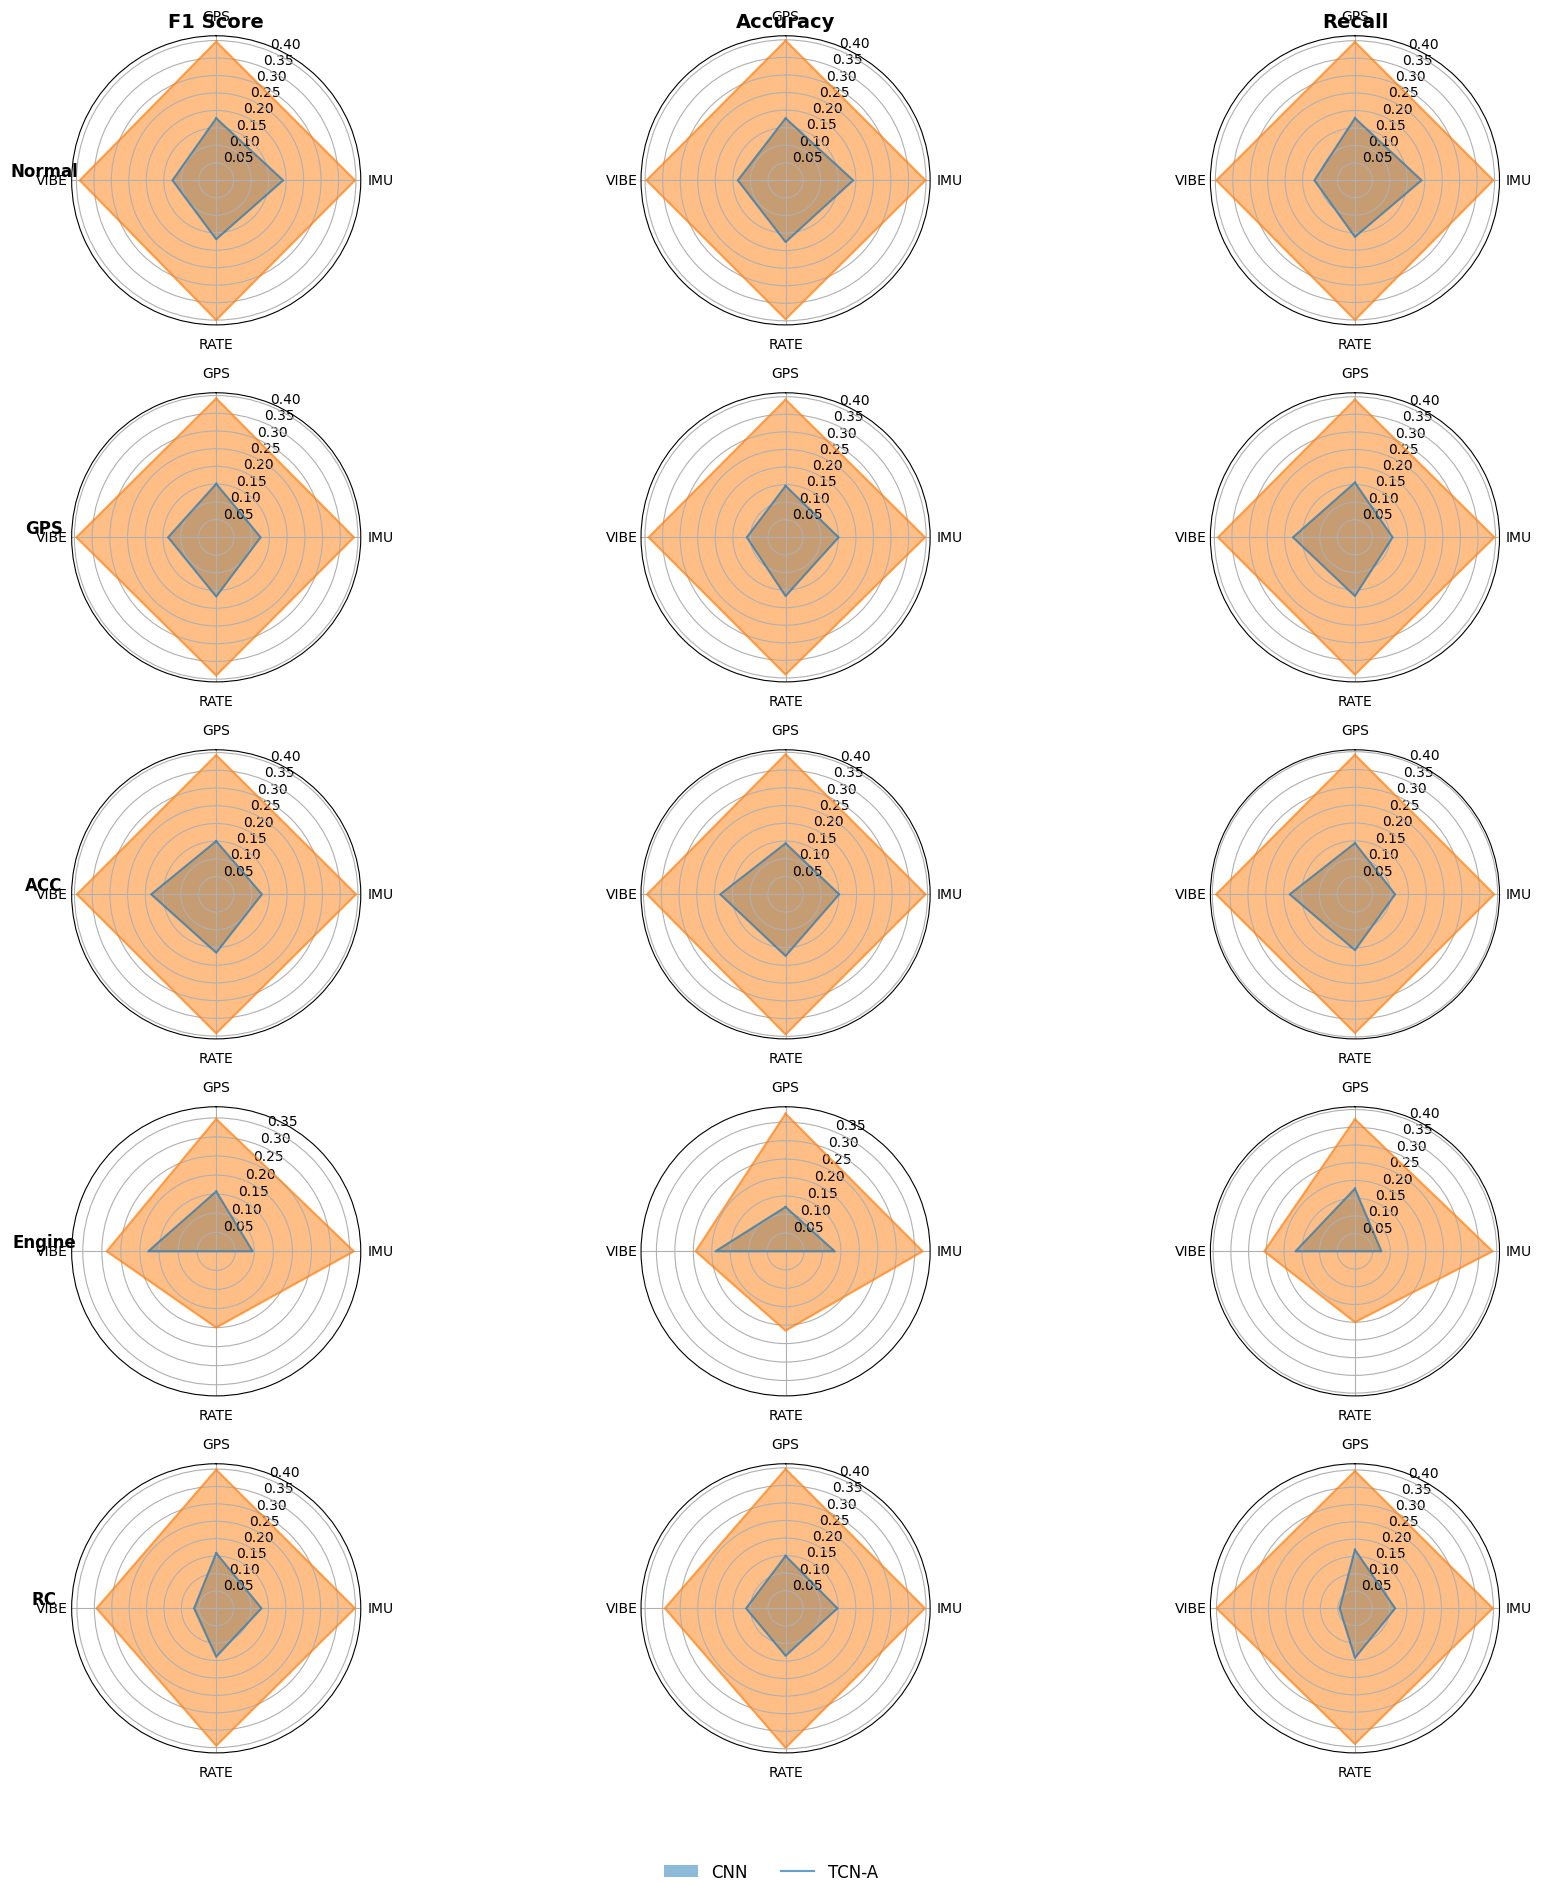

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data reference from the image (replace dummy data with real values as needed)
data = {
    "Accuracy": {
        "CNN": [[0.8846, 0.9632, 0.8792, 0.6802],
                [0.7325, 0.7551, 0.8364, 0.5516],
                [0.7186, 0.7560, 0.8687, 0.9207],
                [0.6010, 0.6666, 0.0000, 0.9512],
                [0.7470, 0.7395, 0.6761, 0.5622]],
        "TCN-A": [[0.9892, 0.9927, 0.9778, 0.9802],
                  [0.9600, 0.9844, 0.9533, 0.9487],
                  [0.9730, 0.9720, 0.9727, 0.9520],
                  [0.8653, 0.8573, 0.0753, 0.2186],
                  [0.9842, 0.9847, 0.9869, 0.7184]]
    },
    "F1 Score": {
        "CNN": [[0.8881, 0.9587, 0.8436, 0.6269],
                [0.7552, 0.6271, 0.8360, 0.6790],
                [0.7506, 0.6459, 0.8240, 0.9182],
                [0.7854, 0.4796, 0.0000, 0.8919],
                [0.7939, 0.6510, 0.6959, 0.3177]],
        "TCN-A": [[0.9852, 0.9865, 1.0000, 0.9530],
                  [0.9600, 0.9434, 0.9493, 0.9717],
                  [0.9653, 0.9737, 0.9624, 0.9664],
                  [0.7363, 0.8058, 0.0000, 0.4367],
                  [0.9923, 0.9926, 0.9743, 0.7184]]
    },
    "Recall": {
        "CNN": [[0.8916, 0.9544, 0.8108, 0.5813],
                [0.7793, 0.5363, 0.8355, 0.8829],
                [0.7186, 0.5639, 0.7837, 0.9157],
                [0.8849, 0.3746, 0.0000, 0.8395],
                [0.8471, 0.5814, 0.7169, 0.2214]],
        "TCN-A": [[0.9828, 0.9821, 1.0000, 0.9861],
                  [0.9608, 0.9844, 0.9538, 0.9487],
                  [0.9576, 0.9526, 0.9455, 0.9474],
                  [0.8654, 0.9420, 0.0000, 0.2793],
                  [0.9847, 0.9917, 0.9601, 1.0000]]
    }
}

# Metadata
labels = ["Normal", "GPS", "ACC", "Engine", "RC"]
metrics = ["F1 Score", "Accuracy", "Recall"]
datasets = ["GPS", "IMU", "RATE", "VIBE"]
models = ["CNN", "TCN-A"]

# Create the 5x3 grid layout for polar charts
fig, axes = plt.subplots(5, 3, figsize=(18, 20), subplot_kw={"polar": True})

# Angles for polar plots (4 datasets + closing loop)
angles = np.linspace(0, 2 * np.pi, len(datasets), endpoint=False).tolist()
angles += angles[:1]

# Plot for each label and metric
for row_idx, label in enumerate(labels):  # Loop over labels
    for col_idx, metric in enumerate(metrics):  # Loop over metrics
        ax = axes[row_idx, col_idx]
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)

        # Dataset labels on plot
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(datasets, fontsize=10)

        # Plot data for both models (concentric rings)
        for model_idx, model in enumerate(models):
            values = data[metric][model][row_idx]  # Data for the current label and metric
            values += [values[0]]  # Close the loop (duplicate the first value)

            # Inner and outer radii for concentric rings
            inner_radius = model_idx * 0.2
            outer_radius = inner_radius + 0.2
            radii = np.array(values) * (outer_radius - inner_radius) + inner_radius

            # Plot the ring as a filled area
            ax.fill(angles, radii, alpha=0.5, label=f"{model}" if col_idx == 0 else None)
            ax.plot(angles, radii, alpha=0.7)

        # Set title for columns (metrics)
        if row_idx == 0:
            ax.set_title(metric, fontsize=14, fontweight="bold")

        # Set y-label for rows (labels)
        if col_idx == 0:
            ax.set_ylabel(label, labelpad=20, fontsize=12, fontweight="bold", rotation=0)

# Adjust layout and add a legend
fig.legend(models, loc="lower center", ncol=2, fontsize=12, frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust space for legend
plt.show()


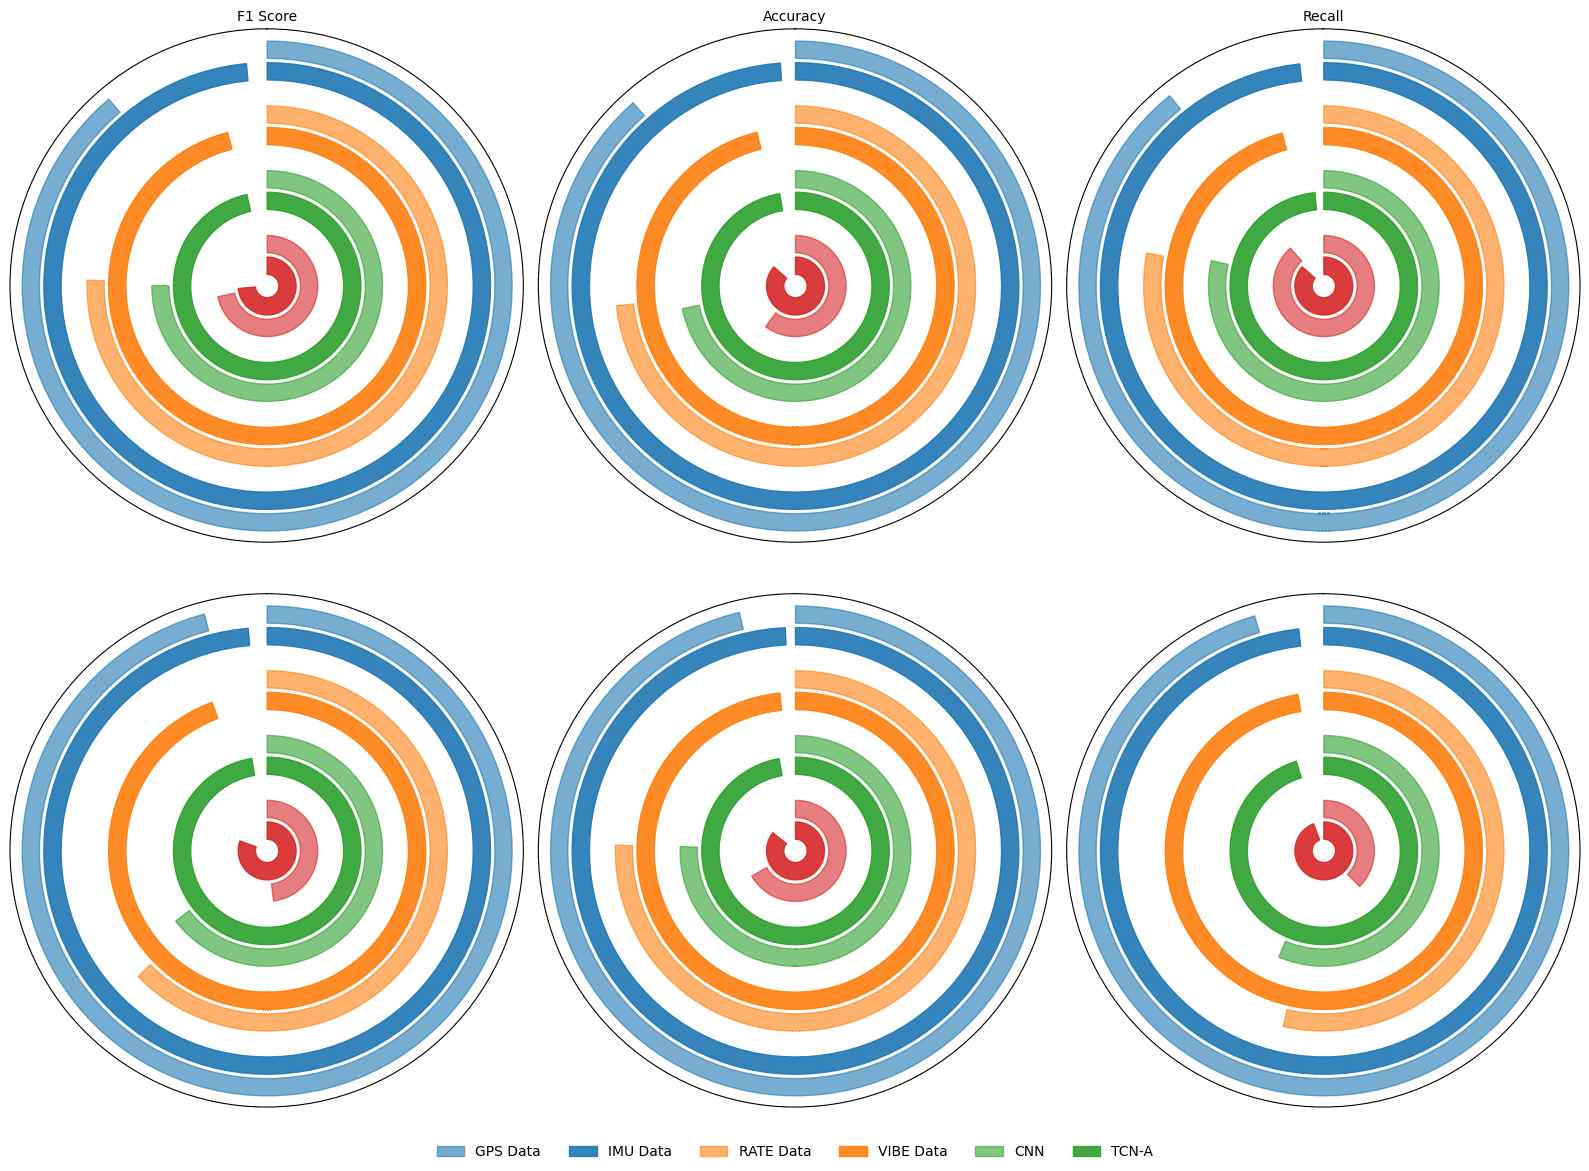

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Organized Data
data = {
    "Normal": {
        "F1 Score": {"GPS Data": [0.8881, 0.9852], "IMU Data": [0.7552, 0.9600], "RATE Data": [0.7506, 0.9653], "VIBE Data": [0.7158, 0.7363]},
        "Accuracy": {"GPS Data": [0.8846, 0.9892], "IMU Data": [0.7325, 0.9608], "RATE Data": [0.7186, 0.9730], "VIBE Data": [0.6010, 0.8653]},
        "Recall": {"GPS Data": [0.8916, 0.9828], "IMU Data": [0.7793, 0.9576], "RATE Data": [0.7854, 0.9848], "VIBE Data": [0.8849, 0.8654]},
    },
    "GPS": {
        "F1 Score": {"GPS Data": [0.9587, 0.9865], "IMU Data": [0.6271, 0.9434], "RATE Data": [0.6459, 0.9737], "VIBE Data": [0.4796, 0.8058]},
        "Accuracy": {"GPS Data": [0.9632, 0.9927], "IMU Data": [0.7551, 0.9844], "RATE Data": [0.7560, 0.9720], "VIBE Data": [0.6666, 0.8573]},
        "Recall": {"GPS Data": [0.9544, 0.9821], "IMU Data": [0.5363, 0.9740], "RATE Data": [0.5639, 0.9526], "VIBE Data": [0.3746, 0.9420]},
    },
    # Continue adding data for "Acc", "Engine", "RC"
}

# Define constants
labels = list(data.keys())  # Rows: Normal, GPS, etc.
metrics = ["F1 Score", "Accuracy", "Recall"]  # Columns
datasets = ["GPS Data", "IMU Data", "RATE Data", "VIBE Data"]
models = ["CNN", "TCN-A"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Colors for datasets

# Create the figure
fig, axes = plt.subplots(len(labels), len(metrics), figsize=(16, 12), subplot_kw={"polar": True})

# Loop through labels and metrics to create the subplots
for row, label in enumerate(labels):  # Rows correspond to labels
    for col, metric in enumerate(metrics):  # Columns correspond to metrics
        ax = axes[row, col]
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        ax.set_yticks([])
        ax.set_xticks([])

        # Get data for the current label and metric
        metric_data = data[label][metric]

        # Plot rings for each dataset
        for i, dataset in enumerate(datasets):
            values = metric_data[dataset]
            for j, value in enumerate(values):  # CNN and TCN-A values
                theta = np.linspace(0, value * 2 * np.pi, 100)
                r_inner = 1.5 - i * 0.3 - j * 0.1  # Adjust radii for stacking models
                r_outer = r_inner + 0.08
                ax.fill_between(theta, r_inner, r_outer, color=colors[i], alpha=0.6 if j == 0 else 0.9)

        # Add titles
        if row == 0:
            ax.set_title(metric, fontsize=10)
        if col == 0:
            ax.text(-2.0, 0.0, label, fontsize=12, rotation=90, ha="center", va="center")

# Add a legend
fig.legend(datasets + models, loc="lower center", ncol=len(datasets + models), fontsize=10, frameon=False)

# Adjust layout
plt.tight_layout()
plt.show()
